In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd

import arviz as az
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import warnings # the warning spam is pointless and annoying
warnings.simplefilter(action="ignore", category=FutureWarning)

Populating the interactive namespace from numpy and matplotlib


# Our idea from last week was to add "momentum" to our Markov chain

\begin{align*}
 \dot{x}(t) & = p(t)\\
 \dot{p}(t) &= \nabla_x L(x(t)).
\end{align*}

## Hamiltonian Monte-Carlo
Goal: generate a markov chain $x_n$, $n=0,1,\ldots,N$.
  1. $p(0) \sim \text{Normal}(0, 1)$ and $x(0) = x_{n-1}$
  2. apply leapfrog integrator forward for $k$ steps, using initial condition $x(0)$ and $p(0)$ from step 1
  3. record the final values, $x_*=x(k\Delta t)$ and $p_*=p(k\Delta t)$
  4. Metropolis-Hastings acceptance probability
  $$P_{MH} = \exp\left(\mathcal{H}(x(0), p(0)) - \mathcal{H}(x_*, p_*)\right)$$
  where
  $$\mathcal{H}(x, p) = -L(x) + \frac{1}{2}p^T p.$$

### If we were to compute solutions to Hamilton's equations exactly, the acceptance probability would be $P_{MH}=1$
  We will prove this below. The fact that $P_{MH}$ can have values less than one is due to the leap-frog approximation scheme.

## The limiting stationary density for the HMC chain will be
$$ f_{\infty}(x, p) = Ce^{-\mathcal{H}(x, p)}, $$
where $C>0$ is a normalization constant.

Notice that
$$ f_{\infty}(x, p) = Ce^{-\mathcal{H}(x, p)} = Ce^{ L(x) - \frac{1}{2}p^Tp}
= Ce^{ L(x)}e^{-\frac{1}{2}p^Tp}
= Cu(x)e^{-\frac{1}{2}p^Tp}
$$

# Test problem

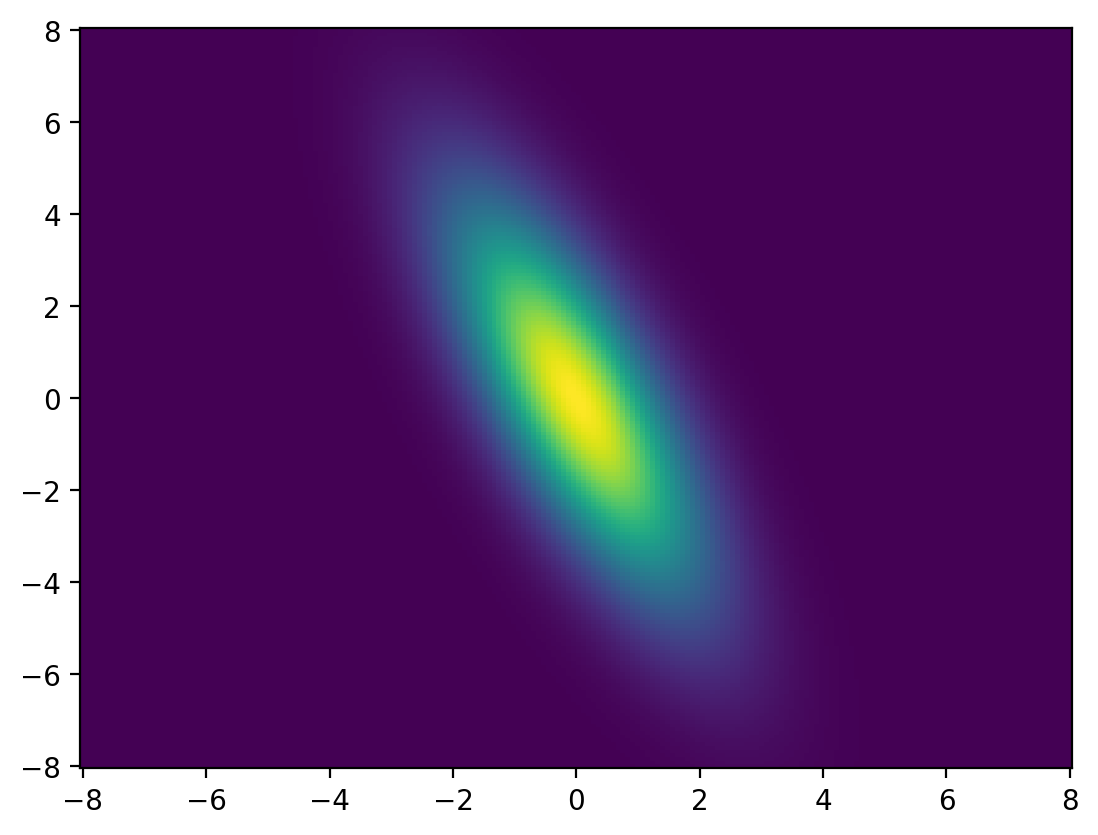

In [2]:
# A = rand(2, 2)
A = array([
    [0.8, 0.05],
    [0.7, 0.5]])
# A = eye(2)


M = A.T@A
def L(_x):
    xT = _x[..., None, :]
    x = _x[..., None]
    return -0.5*(xT@M@x)[..., 0, 0]

def gradL(x):
    return -(A@x[..., None])[..., 0]

def H(x, p):
    return -L(x) + 0.5*(p**2).sum(axis=-1)

x = linspace(-8, 8, 200)
y = x
X, Y = meshgrid(x, y)
Z = L(stack([X, Y], 2))

pcolor(X, Y, exp(Z))

# Example of Hamiltonian velocity jump MCMC in Python

In [3]:
Nsteps = 1000
N_burn_in = 10
Nchains = 4
lam = 0.1
dt = 0.025

## initial guess
x = 0.*ones((Nchains, 2))

## Burn in phase
for n in arange(N_burn_in):
    p0 = normal(0, 1, [Nchains, 2])
    p = p0.copy()
    tau = -log(rand(1))/lam ## generate an exponential RV for time
    K = tau//dt
    p += 0.5*dt*gradL(x)
    for k in arange(K):
        x += dt*p
        p += dt*gradL(x)

Xchain = zeros((Nsteps, Nchains, 2))
Xchain[0, ...] = x ## use final value from burin-in as initial guess
probs = zeros((Nsteps, Nchains))
acceptances = ones((Nsteps, Nchains))
Kmean = 0.
for n in arange(Nsteps-1):
    p0 = normal(0, 1, [Nchains, 2])
    p = p0.copy()
    x0 = Xchain[n, ...]
    x = x0.copy()
    tau = -log(rand(1))/lam ## generate an exponential RV for time
    K = tau//dt
    Kmean += K

    ## forward Euler
    # for k in arange(K):
    #     gL = gradL(x)
    #     x += dt*p
    #     p += dt*gL

    ## Leap Frog
    p += 0.5*dt*gradL(x)
    for k in arange(K):
        x += dt*p
        p += dt*gradL(x)

    pMH = exp(H(x0, p0) - H(x, p))
    u = rand(Nchains)
    log_p_MH = H(x0, p0) - H(x, p)
    probs[n, :] = exp(log_p_MH)
    u = rand(Nchains)
    chi = 1.*(log(u) < log_p_MH)
    # chi = 1.*(u < exp(log_p_MH))
    acceptances[n+1, :] = chi
    Xchain[n+1, ...] = x0*(1 - chi[:, None]) + x*chi[:, None]

print('acceptance ratio:', acceptances.sum(axis=0)/Nsteps)
print('mean number of leap frog steps:', Kmean/Nsteps)

<ipython-input-3-72a499e5051b>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for k in arange(K):
<ipython-input-3-72a499e5051b>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for k in arange(K):


acceptance ratio: [0.378 0.467 0.455 0.409]
mean number of leap frog steps: [392.68]


([], [])

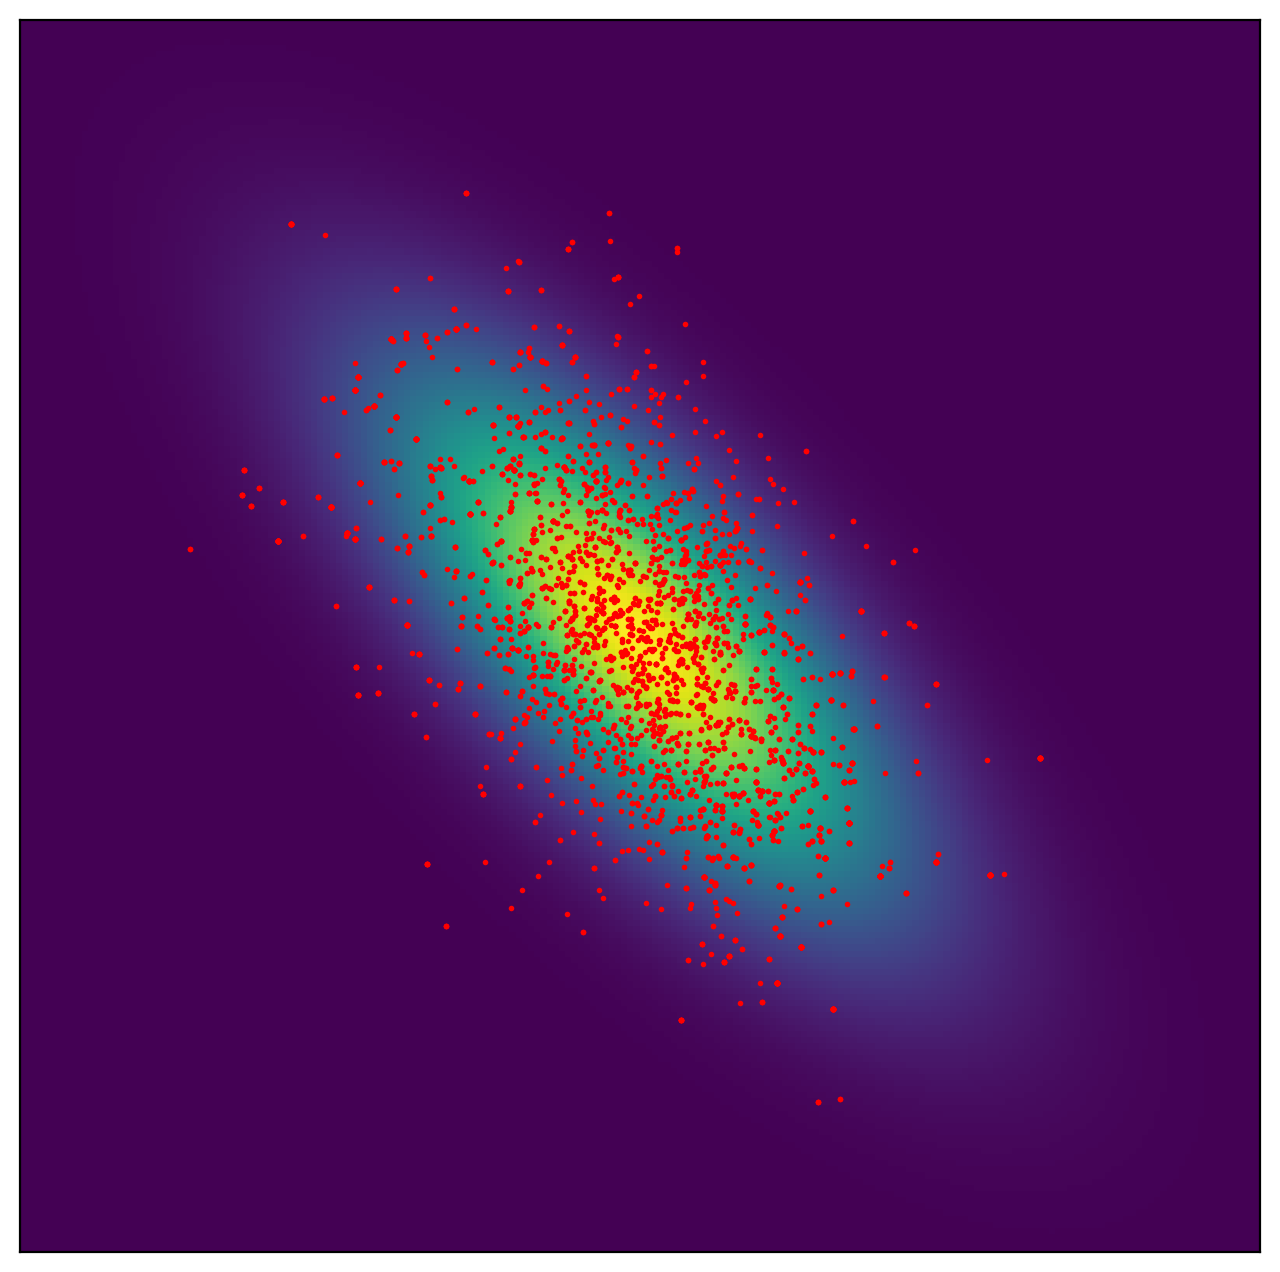

In [4]:
x = linspace(-5, 5, 200)
y = linspace(-10, 10, 200)
X, Y = meshgrid(x, y)
Z = L(stack([X, Y], 2))
figure(1, [8, 8])
pcolor(X, Y, exp(Z))
plot(Xchain[..., 0].flatten(), Xchain[..., 1].flatten(), 'r.', ms=2)
xticks([])
yticks([])

In [5]:
tfp.mcmc.effective_sample_size(Xchain)

<tf.Tensor: shape=(4, 2), dtype=float64, numpy=
array([[ 33.90845777,  32.61848348],
       [ 98.46303786, 143.61979205],
       [ 87.71088195, 161.19806104],
       [ 48.08768955, 124.44065082]])>

In [6]:
print('mean:', Xchain.mean(axis=(0, 1)))
print('estimated covariance:\n', cov(Xchain.reshape(-1, 2).T))
print('true covariance:\n', inv(M))

mean: [-0.06152186 -0.00203403]
estimated covariance:
 [[ 1.35308017 -1.82841638]
 [-1.82841638  6.58101187]]
true covariance:
 [[ 1.89528992 -2.9273785 ]
 [-2.9273785   8.48189154]]


# Definition: Phase Space
We call the pair $x, p \in \mathbb{R}^d \times\mathbb{R}^d$ the phase space.

# Hamiltonian dynamical system has a constant of motion
One can show that the "energy"
$$\mathcal{H}(x, p) = -L(x) + \frac{1}{2}p^T p,$$
is constant (wrt time) along solutions to the Hamiltonian ODEs. That is, if $x(t)$ and $p(t)$ are solutions to the ODE, then
$$\mathcal{H}(x(t), p(t)) = -L(x(t)) + \frac{1}{2}p(t)^T p(t) = \text{constant wrt }t $$

Recall
\begin{align*}
 \dot{x}(t) & = p(t)\\
 \dot{p}(t) &= \nabla_x L(x(t)).
\end{align*}
The equations can be rewritten
\begin{align*}
 \dot{x}(t) & = \nabla_p \mathcal{H}(x(t), p(t))\\
 \dot{p}(t) &= - \nabla_x \mathcal{H}(x(t), p(t)).
\end{align*}

Now take the derivative with respect to time
$$ \frac{d}{dt}\mathcal{H}(x(t), p(t)) = \nabla_x\mathcal{H}^T\frac{dx}{dt} +  \nabla_p\mathcal{H}^T\frac{dp}{dt}
=
\nabla_x\mathcal{H}^T\nabla_p \mathcal{H} +  \nabla_p\mathcal{H}^T(- \nabla_x \mathcal{H}) = 0
$$

### Note that the Hamiltonian will not be constant if we use the leap-frog integrator to approximate solutions to these equations

# Volume and density are preserved along trajectories of the Hamiltonian dynamics
## Liouville's Theorem:
Let $\mathcal{H}(x, p)$ be smooth and continuous (i.e., $C^2(\mathbb{R}^d \times \mathbb{R}^d)$), and let it be a convex function of the variable $p\in \mathbb{R}^d$. Let $f_0(x, p)$ be a probability density function on the phase space. **The density function can be any valid function of $x$ and $p$ that satisfies the requirements of a probability density.**

Let $$x, p = \varphi_t(x_0, p_0)$$ be the phase-space flow of the dynamics
\begin{align*}
 \dot{x}(t) & = \nabla_p \mathcal{H}(x(t), p(t))\\
 \dot{p}(t) &= - \nabla_x \mathcal{H}(x(t), p(t)),
\end{align*}
with $x_0, p_0 = \varphi_0(x_0, p_0)$. From time reversibility we know that
$$x_0, -p_0 = \varphi_t(x, -p).$$

Define the density function $f(x, p | t) = f_0(\varphi_{-t}(x, p))$ satisfying
$$ f(x, p | 0) = f_0(x, p), $$
and
$$ L_t f(x(t), p(t) | t)
= \frac{\partial f}{\partial t} +
\sum_{i=1}^d\left(\frac{\partial f}{\partial x_i}\dot{x}_i + \frac{\partial f}{\partial p_i}\dot{p}_i\right) = 0,$$
where $L_t$ denotes the total (or orbital) derivative with respect to time $t$. **(It's just the chain rule).**

Then, along trajectories of the system,

the density function $f$ is constant.


Proof: (will fill this in)

# Time reversibility

Hamiltonian dynamics has the remarkable property that under the reflection $p \to -p$, the dynamics runs in backward time. It is like instantly playing a GIF in reverse. The motion of the trajectory retraces its path perfectly back to its original state (with reflected momentum $-p_0$). That is,
$$p0, x0 \to p_{\tau}, x_{\tau}, \quad  -p_{\tau}, x_{\tau} \to -p0, x0 $$

$$x_{\tau}, p_{\tau} = \varphi_{\tau}((x_0, p_0))$$
$$x_{0}, -p_{0} = \varphi_{\tau}((x_{\tau}, -p_{\tau}))$$

## Example: harmonic oscillator
Let
$$L(x) = -\frac{x^2}{2}$$
so that we have the Hamiltonian dynamics given by
$$ \dot{x}  = p, \quad \dot{p} = -x ,$$
with initial conditions $x(0) = x_0$ and $p(0) = p_0$. This is equivalent to having a spring attached to a mass sliding on a frictionless surface. It is also an approximation of the motion of a pendulum.

The exact solution is given by
$$x(t) = x_0\cos(t) + p_0\sin(t), \quad p(t) = -x_0\sin(t) + p_0\cos(t).$$
We can verify this by substituting the solution into the equation, which we leave as an excersize.

Notice that, due to the even and odd symmetry of `cos()` and `sin()`, we have
$$x(-t) = x_0\cos(-t) + p_0\sin(-t) = x_0\cos(t) - p_0\sin(t).$$
Hence, the backward time solution is given by $p_0 \to -p_0$.


## A continuous time Hamiltonian velocity-jump process
We can prove under reasonable assumptions that the Hamiltonian Markov chain, generalized to the case of random times $\tau \sim \text{Exponential}(\lambda)$, has a stationary density given by the *canonical distribution*,
$$ \pi(x, p) = \pi(x)\pi(p | x) \propto \exp( L(x))\exp( - \frac{1}{2}p^T M(x) p) = \exp( L(x) - \frac{1}{2}p^T M(x) p) = e^{-\mathcal{H}(x, p)},$$
where
$$ \mathcal{H}(x, p) = -L(x) + \frac{1}{2}p^T M(x) p .$$

The Hamiltonian velocity jump can be described as a deterministic path of the equation $(\dot{x}, \dot{p}) = F(x, p)$, where
$$F(x, p) =
\begin{bmatrix}
 \nabla_p \mathcal{H}(x, p) \\
 -\nabla_x \mathcal{H}(x, p)
\end{bmatrix} =
\begin{bmatrix}
 Mp \\
 \nabla_x L(x)
\end{bmatrix},
$$
interupted at random time intervals $\tau$ by a random jump in the momentum $p$. In between these random jumps at random times, the dynamics are deterministic. Hence, all stochasticity or "noise" comes from the random jumps in momentum.

## All Markov processes satisfy a Chapman-Kolmogorov equation
Let $u(x, p, t | x_0, t_0)$ be the probability density for the process $X(t), P(t)$ such that $X(t_0) = x_0$ and $P(0) \sim \text{Normal}(0, \sqrt{M^{-1}(x_0)})$. One can show that the density $u$ satisfies the integro-partial differential equation$^{1}$,
$$ \frac{\partial }{\partial t}u(x, p, t) = -\nabla_{x,p} \cdot (F(x, p) u(x, p, t)) + \lambda \int dx'\int dp' \left[W(x, p | x', p')u(x', p', t) - W(x', p' | x, p)u(x, p, t) \right], $$
with the initial condition
$$ u(x, p, t_0) = \delta(x - x_0)\text{Gaussian}(p | \mu=0, \text{cov}=M^{-1}(x_0)).$$
The density $W()$ is called the jump transition density. Given a jump occurs at time $t$, the probability density for the state to jump from $x',p'$ to $x, p$ is given by $W(x, p | x', p')$.

In our case, the jump transitions (resetting the momentum at the begining of each step) is given by $W(x, p, | x', p') = \delta(x - x')W(p | x'),$ where $W(p | x) = \text{Gaussian}(p | \mu=0, \text{cov}=M^{-1}(x))$.

The Chapman-Kolmogorov equation becomes
$$\frac{\partial }{\partial t}u(x, p, t) = -\nabla_{x,p} \cdot(F(x, p) u(x, p, t)) + \lambda  \left[W(p | x)\int dp'u(x, p', t) - u(x, p, t) \right] .$$

*1. One place to find a rigorous treatment of the differential form of the Chapman-Kolmogorov equation is Freidlin and Wentzell 2012 (https://books.google.com/books?hl=en&lr=&id=p8LFMILAiMEC&oi=fnd&pg=PR6&ots=-BHn--qj3x&sig=Acmz6q3DhxEShDFk44Bbr0G1g0o)*

## Stationary Chapman-Kolmogorov equation
We want to pick the details of the Hamiltonian velocity jump transitions so that the above is the stationary density of the process. We will assume ergodicity and uniqueness of the solution to the stationary Chapman-Kolmogorov equation, which is given by
$$ 0= -\nabla_{x,p} \cdot(F(x, p) \pi(x, p)) + \lambda \left[W(p | x)\int dp'\pi(x, p') - \pi(x, p) \right] .$$
Note that convergence to the given stationary distribution should be independent of the jump rate $\lambda > 0$.

Let $\pi(x, p) = \pi(p | x)\pi(x)$. The stationary CK equation becomes,
$$ 0 = -\nabla_{x,p} \cdot(F(x, p) \pi(p | x)\pi(x)) + \lambda  \left[W(p | x)\pi(x) - \pi(p | x)\pi(x) \right] $$
$$ = -\nabla_{x,p} \cdot(F(x, p)\pi(p | x)\pi(x)) + \lambda \pi(x) \left[W(p | x) - \pi(p | x) \right] .$$

If we set $W(p | x) = \pi(p | x)$ (a detailed balance requirement) then the last term on the right hand side vanishes and we are left with
$$ 0 = -\nabla_{x,p} \cdot(F(x, p)\pi(p | x)\pi(x)) $$
We have two approaches to show the remaining term vanishes

## Generalized detailed balance conditions guarantee a stationary distribution
Beyond the definition of detailed balance shown in a previous cell, one can go further and derive conditions for specific types of Markov processes [see Gardner: Handbook of Stochastic Methods, 3rd edition, pg 151].

For our case, detailed balance is satisfied if
$$ \begin{bmatrix}
I & \\
 & -I
\end{bmatrix}
F(\begin{bmatrix}
I & \\
 & -I
\end{bmatrix}
\begin{bmatrix} x \\ p \end{bmatrix}
) = - F(\begin{bmatrix} x \\ p \end{bmatrix}) $$
The detailed balance condition is satisfied if
$$F(x, p) =
\begin{bmatrix}
 \nabla_p \mathcal{H}(x, p) \\
 -\nabla_x \mathcal{H}(x, p)
\end{bmatrix} =
\begin{bmatrix}
 p \\
 \nabla_x L(x)
\end{bmatrix} .
$$
We have
$$ \nabla_p \mathcal{H}(x, -p) = - \nabla_p \mathcal{H}(x, p)$$
$$ -I(-\nabla_x \mathcal{H}(x, -p)) = -(-\nabla_x \mathcal{H}(x, p)) $$
$$\Rightarrow \nabla_x \mathcal{H}(x, -p) = \nabla_x \mathcal{H}(x, p) $$
This shows that there must be a certain symmetry in the momentum, which is true for our choice of Hamiltonian because $\nabla_p \mathcal{H}(x, p) = p$ has odd symmetry and $\nabla_x \mathcal{H}(x, p) = \nabla_x L(x)$ is independent of $p$.

**Conjecture: If the symplectic integrators that we use to numerically solve the ODEs in between jumps has similar properties (time reversibility, energy conserving, and volume preserving). Then, the numerical solution is the exact solution to a Hamiltonian ODE with a perturbed Hamiltonian function $\hat{\mathcal{H}}(x, p)$. Therefore, the numerical simulation scheme also satisfies detailed balance.**

## Stationary solution is canonical density (assuming existence and uniqueness)
We assume that the given function $L(x)$ and $\mathcal{H}(x, p)$ are sufficiently smooth so that the Hessian matrix is symmetric. Continuing from above, we want to show that
$$ -\nabla_{x,p} \cdot(F(x, p)\pi(x, p)) = 0 $$

For a Hamiltonian system, the above equation becomes
$$ \nabla_x \cdot (\pi(x, p) \nabla_p \mathcal{H}(x, p)) =
 \nabla_p \cdot (\pi(x, p)\nabla_x \mathcal{H}(x, p))
$$
$$\Rightarrow \nabla_x (\pi(x, p))\cdot  \nabla_p \mathcal{H}(x, p)
=
 \nabla_p \pi(x, p)\cdot  \nabla_x \mathcal{H}(x, p)
$$
Finally writting $\pi(x, p) \propto \exp(-U(x, p))$ then
$$ -\exp(-U(x, p))\nabla_x U(x, p) \cdot  \nabla_p \mathcal{H}(x, p)  
= - \exp(-U(x, p))\nabla_p U(x, p) \cdot  \nabla_x \mathcal{H}(x, p) $$
$$\Rightarrow \nabla_x U(x, p) \cdot  \nabla_p \mathcal{H}(x, p)  
= \nabla_p U(x, p) \cdot  \nabla_x \mathcal{H}(x, p) .$$
Clearly this is satisfied if $U(x, p) = \mathcal{H}(x, p).$

# HMC using Tensorflow Probability


In [7]:
Nsteps = 100
N_burn_in = 10
Nchains = 4
dt = 0.1

Xinit = 0.*ones((Nchains, 2))

kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=L,
    num_leapfrog_steps=10,
    step_size=dt)

Xchain = tfp.mcmc.sample_chain(
    num_results=Nsteps,
    num_burnin_steps=N_burn_in,
    current_state=Xinit,
    trace_fn=None,
    kernel=kernel,
    parallel_iterations=4)

In [8]:
Nsteps = 5000
N_burn_in = 100
Nchains = 16

Xinit = 0.*ones((Nchains, 2))

# A = rand(2, 2)
A = array([
    [0.8, 0.05],
    [0.7, 0.5]])
# A = eye(2)

M = A.T@A

@tf.function(
    input_signature=(
            tf.TensorSpec(shape=[None, 2], dtype=tf.float64),))
def Ltf(_x):
    xT = _x[..., None, :]
    x = _x[..., None]
    return -0.5*(xT@M@x)[..., 0, 0]

@tf.function()
def sampler():
    def trace_everything(states, previous_kernel_results):
        return previous_kernel_results

    kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=Ltf,
        max_tree_depth=8, ## possible max # steps --- 2^max_tree_depth
        max_energy_diff=1000,
        step_size=tf.cast(0.1, tf.float64))

    # kernel = tfp.mcmc.HamiltonianMonteCarlo(
    #     target_log_prob_fn=Ltf,
    #     num_leapfrog_steps=10,
    #     step_size=tf.cast(0.1, tf.float64))

    # adaptive_kernel = kernel

    adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8 * N_burn_in),
        target_accept_prob=tf.cast(0.7, tf.float64))

    # adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    #     inner_kernel=kernel,
    #     num_adaptation_steps=int(0.8*N_burn_in))

    Xchain, trace = tfp.mcmc.sample_chain(
        num_results=Nsteps,
        num_burnin_steps=N_burn_in,
        current_state=Xinit,
        trace_fn=trace_everything,
        kernel=adaptive_kernel,
        parallel_iterations=4)
    return Xchain, trace
Xchain, trace = sampler()

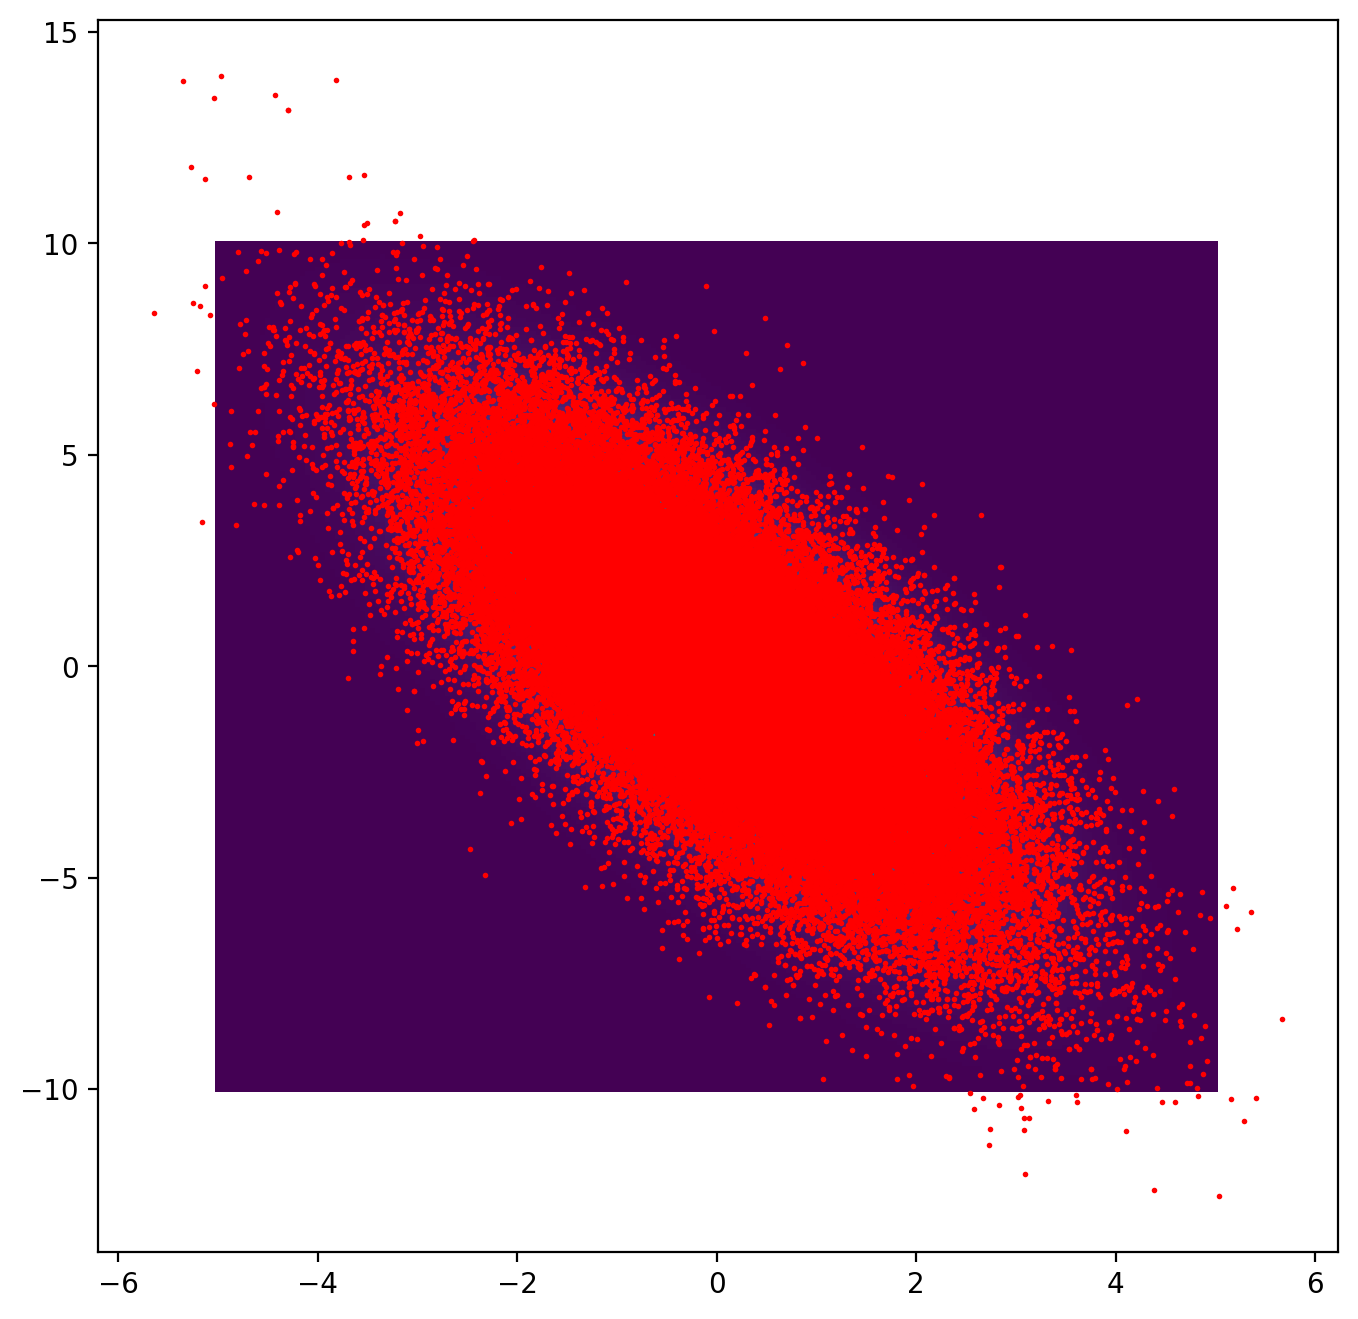

In [9]:
Xchain = array(Xchain)
x = linspace(-5, 5, 200)
y = linspace(-10, 10, 200)
X, Y = meshgrid(x, y)
Z = L(stack([X, Y], 2))
figure(1, [8, 8])
pcolor(X, Y, exp(Z))
plot(Xchain[..., 0].flatten(), Xchain[..., 1].flatten(), 'r.', ms=2)

In [10]:
tfp.mcmc.effective_sample_size(Xchain)

<tf.Tensor: shape=(16, 2), dtype=float64, numpy=
array([[1418.30962399, 1206.2771158 ],
       [1716.89421632, 1343.99853507],
       [1573.05378229, 1093.59810161],
       [1848.15281689, 1417.31177191],
       [1658.32872761, 1314.82528359],
       [1831.00420805, 1114.03190299],
       [1806.09875573, 1388.20538511],
       [1582.72294933, 1062.65824156],
       [1684.20694889, 1303.87659771],
       [1786.07431446, 1290.09256274],
       [1422.27308696, 1027.70633106],
       [1988.9765045 , 1234.27512057],
       [1803.77271023, 1215.48815125],
       [1794.7237997 , 1273.87634664],
       [1644.1472131 , 1287.14504532],
       [1710.94373227, 1292.76584134]])>

In [11]:
print('mean:', Xchain.mean(axis=(0, 1)))
print('estimated covariance:\n', cov(Xchain.reshape(-1, 2).T))
print('true covariance:\n', inv(M))

mean: [-0.00021561 -0.0120927 ]
estimated covariance:
 [[ 1.87196371 -2.89861463]
 [-2.89861463  8.44177845]]
true covariance:
 [[ 1.89528992 -2.9273785 ]
 [-2.9273785   8.48189154]]


In [12]:
mean(trace.inner_results.is_accepted, axis=0)

array([0.9316, 0.9308, 0.9372, 0.9328, 0.9334, 0.9332, 0.934 , 0.9358,
       0.9412, 0.9382, 0.9354, 0.9366, 0.9446, 0.9396, 0.936 , 0.9336])

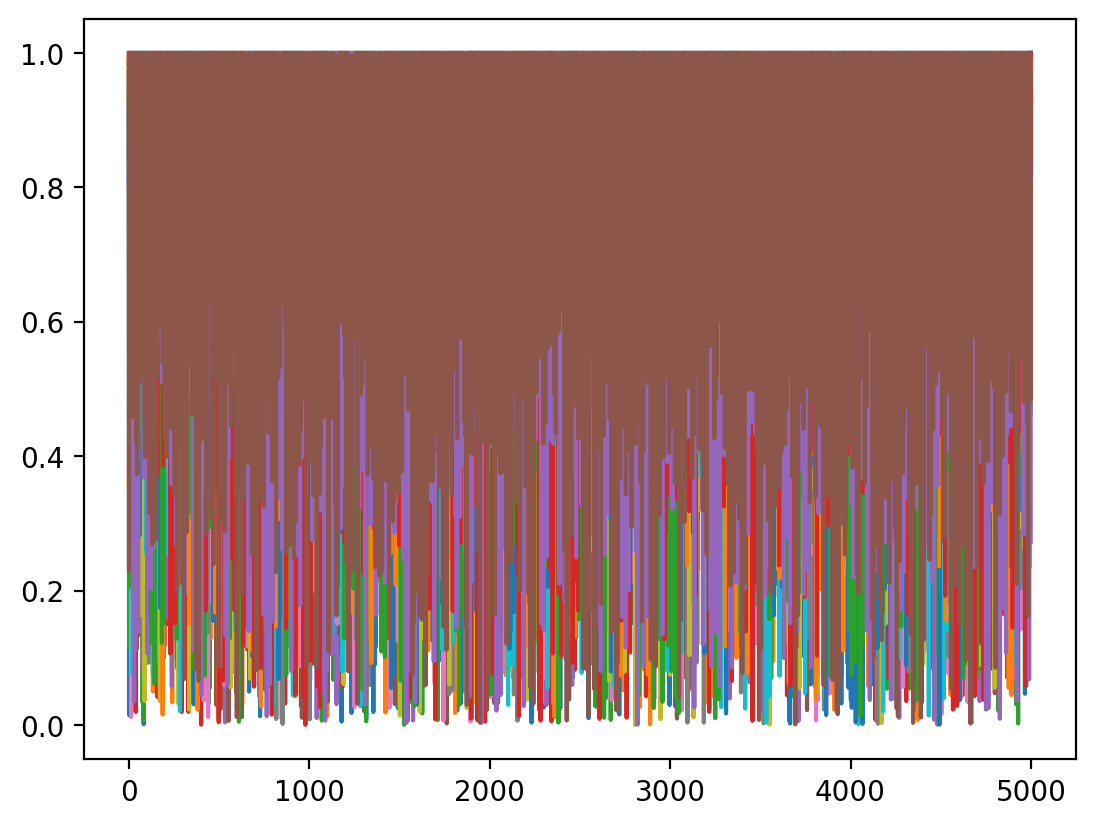

In [13]:
plot(exp(trace.inner_results.log_accept_ratio));

# No U-Turn Sampler (NUTS)
The No U-Turn Sampler is based on the same idea as HMC. Instead of integrating forward a fixed number of leap-frog steps, the NUTS applies leapfrog forward and backward in time until a loop is formed. The solution is saved at every step of leap-frog. A point is sampled from the resulting trajectory.

total time: 20.0


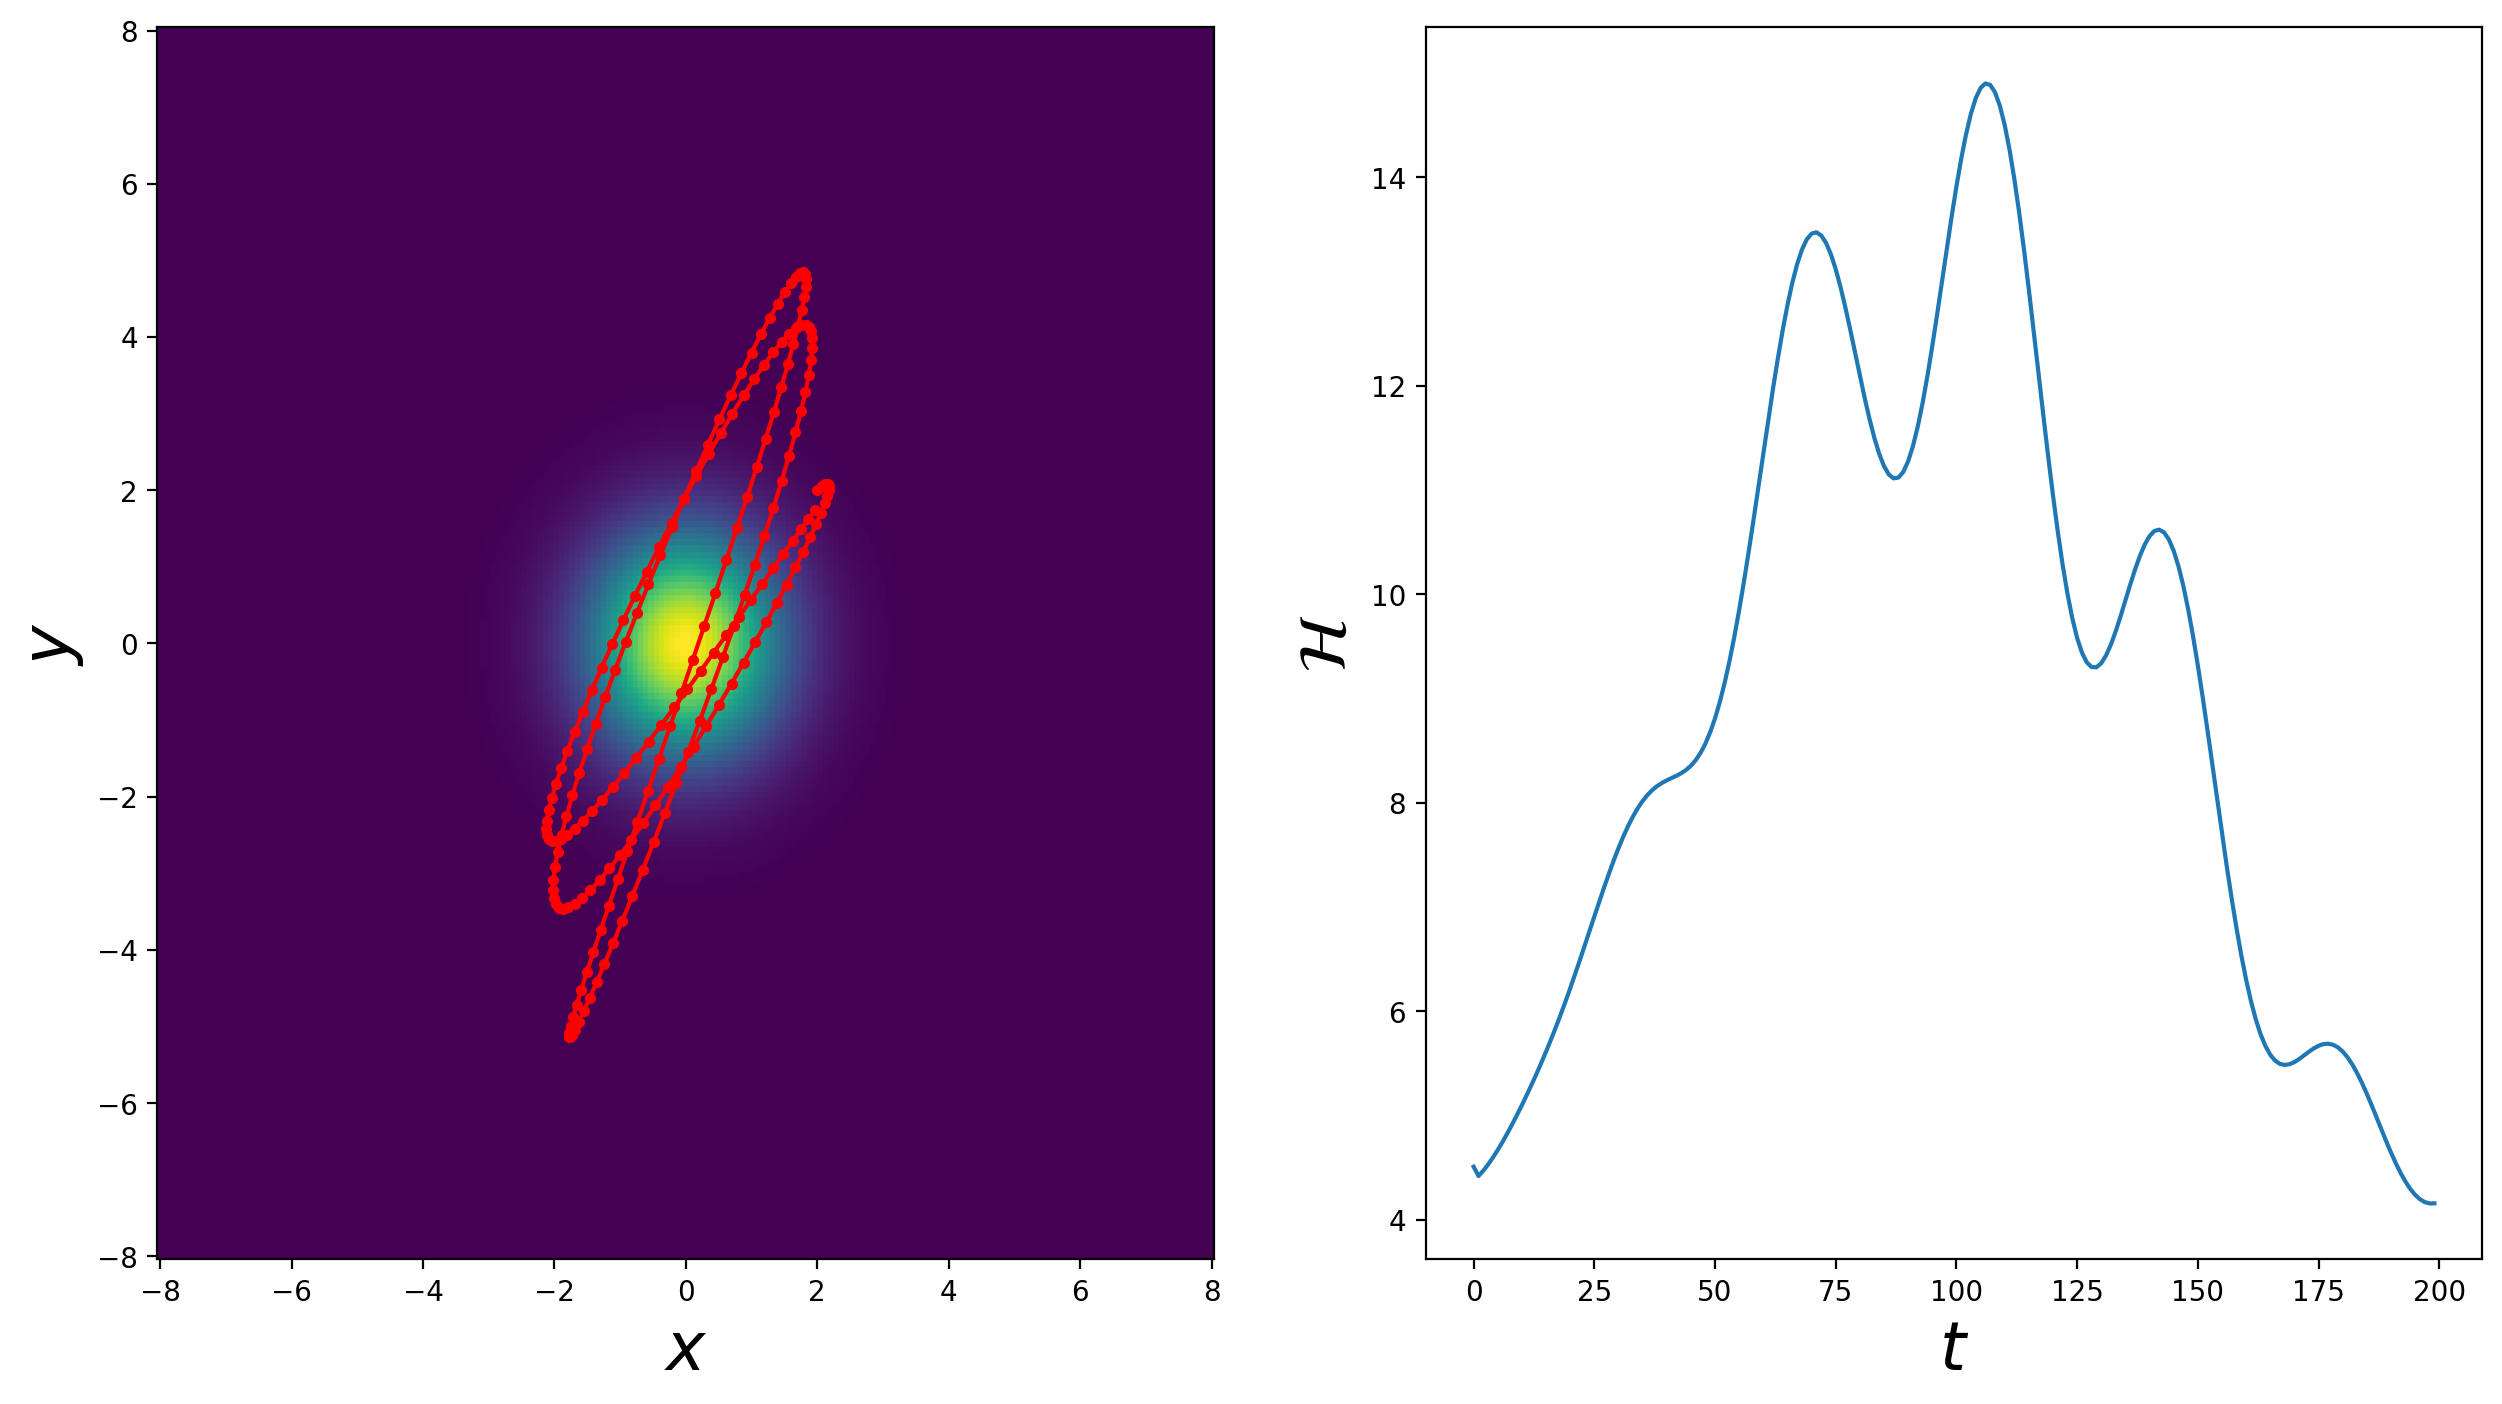

In [14]:
M = eye(2)
def L(_x):
    """Random quadratic form. Input _x assumes rightmost dimension is size 2"""
    xT = _x[..., None, :]
    x = _x[..., None]
    return -0.5*(xT@M@x)[..., 0, 0]
def gradL(x):
    """The exact gradient of a quadratic form"""
    return -(A@x[..., None])[..., 0]
def H(x, p):
    return -L(x) + 0.5*(p**2).sum(axis=-1)

x = linspace(-8, 8, 200)
y = x
X, Y = meshgrid(x, y)
Z = L(stack([X, Y], 2))

K = 200
dt = 0.1

Xsol = zeros([K, 2])
Psol = zeros([K, 2])

Xsol[0, :] = [2., 2.]
Psol[0, :] = normal(0, 1, [2])

x = Xsol[0].copy()
p = Psol[0] + 0.5*dt*gradL(x)
for k in arange(1, K):
    x += dt*p
    # same as x = x + dt*p
    p += dt*gradL(x)
    Xsol[k] = x
    Psol[k] = p

print('total time:', K*dt)

fig = figure(1, [15, 8])

fig.add_subplot(121)
pcolor(X, Y, exp(Z))
plot(Xsol[:, 0], Xsol[:, 1], '-r.')
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

fig.add_subplot(122)
plot(H(Xsol, Psol))
xlabel(r'$t$', fontsize=24)
ylabel(r'$\mathcal{H}$', fontsize=24);

# Tensorflow + velocity jump HMC

In [15]:
Nsteps = 10000
N_burn_in = 100
Nchains = 16

lam = 0.1
dt = 0.1

x0 = normal(0, 1, [Nchains, 2])
# A = rand(2, 2)
A = array([
    [0.8, 0.05],
    [0.7, 0.5]])
# A = eye(2)
M = A.T@A

@tf.function()
def sample(x0):

    def L(_x):
        xT = _x[..., None, :]
        x = _x[..., None]
        return -0.5*(xT@M@x)[..., 0, 0]
    def gradL(x):
        return -(A@x[..., None])[..., 0]
    def H(x, p):
        return -L(x) + 0.5*tf.reduce_sum(p**2, axis=-1)

    x = tf.identity(x0) ## make a copy of the values in the Variable x0

    ## Burn in steps
    for j in tf.range(N_burn_in): ## notice that this is not `arange` or `range`
        p0 = tf.random.normal(
            mean=0, stddev=1, shape=[Nchains, 2], dtype=tf.float64)
        p = tf.identity(p0) ## make a copy of p0
        ## generate an exponential RV for time
        tau = -tf.math.log(tf.random.uniform(shape=[1]))/lam
        K = tf.cast(tau/dt, tf.int64) ## cast (convert) a float to an integer
        p = p + 0.5*dt*gradL(x)
        for k in tf.range(K[0]):
            x = x + dt*p
            p = p + dt*gradL(x)
    ## We have to use this to store values in a tensorflow loop
    Xchain = tf.TensorArray(
        tf.float64,
        size=Nsteps,
        element_shape=[Nchains, 2])
    ## The write method saves a time step (the first in this case)
    Xchain = Xchain.write(0, x)

    for j in tf.range(Nsteps-1):
        p0 = tf.random.normal(
            mean=0, stddev=1, shape=[Nchains, 2], dtype=tf.float64)
        x0 = tf.identity(x) ## make a copy of the values in the Variable x
        p = tf.identity(p0)
        ## generate an exponential RV for time
        tau = -tf.math.log(tf.random.uniform(shape=[1]))/lam
        K = tf.cast(tau/dt, tf.int64)
        p = p + 0.5*dt*gradL(x)
        for k in tf.range(K[0]):
            x = x + dt*p
            p = p + dt*gradL(x)
        log_p_MH = H(x0, p0) - H(x, p)
        u = tf.random.uniform(shape=[Nchains, 1], dtype=tf.float64)
        ## `tf.cast` used to convert a boolean (True/False) to a float64
        chi = tf.cast(tf.math.log(u) < log_p_MH[..., None], tf.float64)
        x = x0*(1 - chi) + x*chi
        Xchain = Xchain.write(j+1, x)
    return Xchain.stack()
Xchain = array(sample(x0))

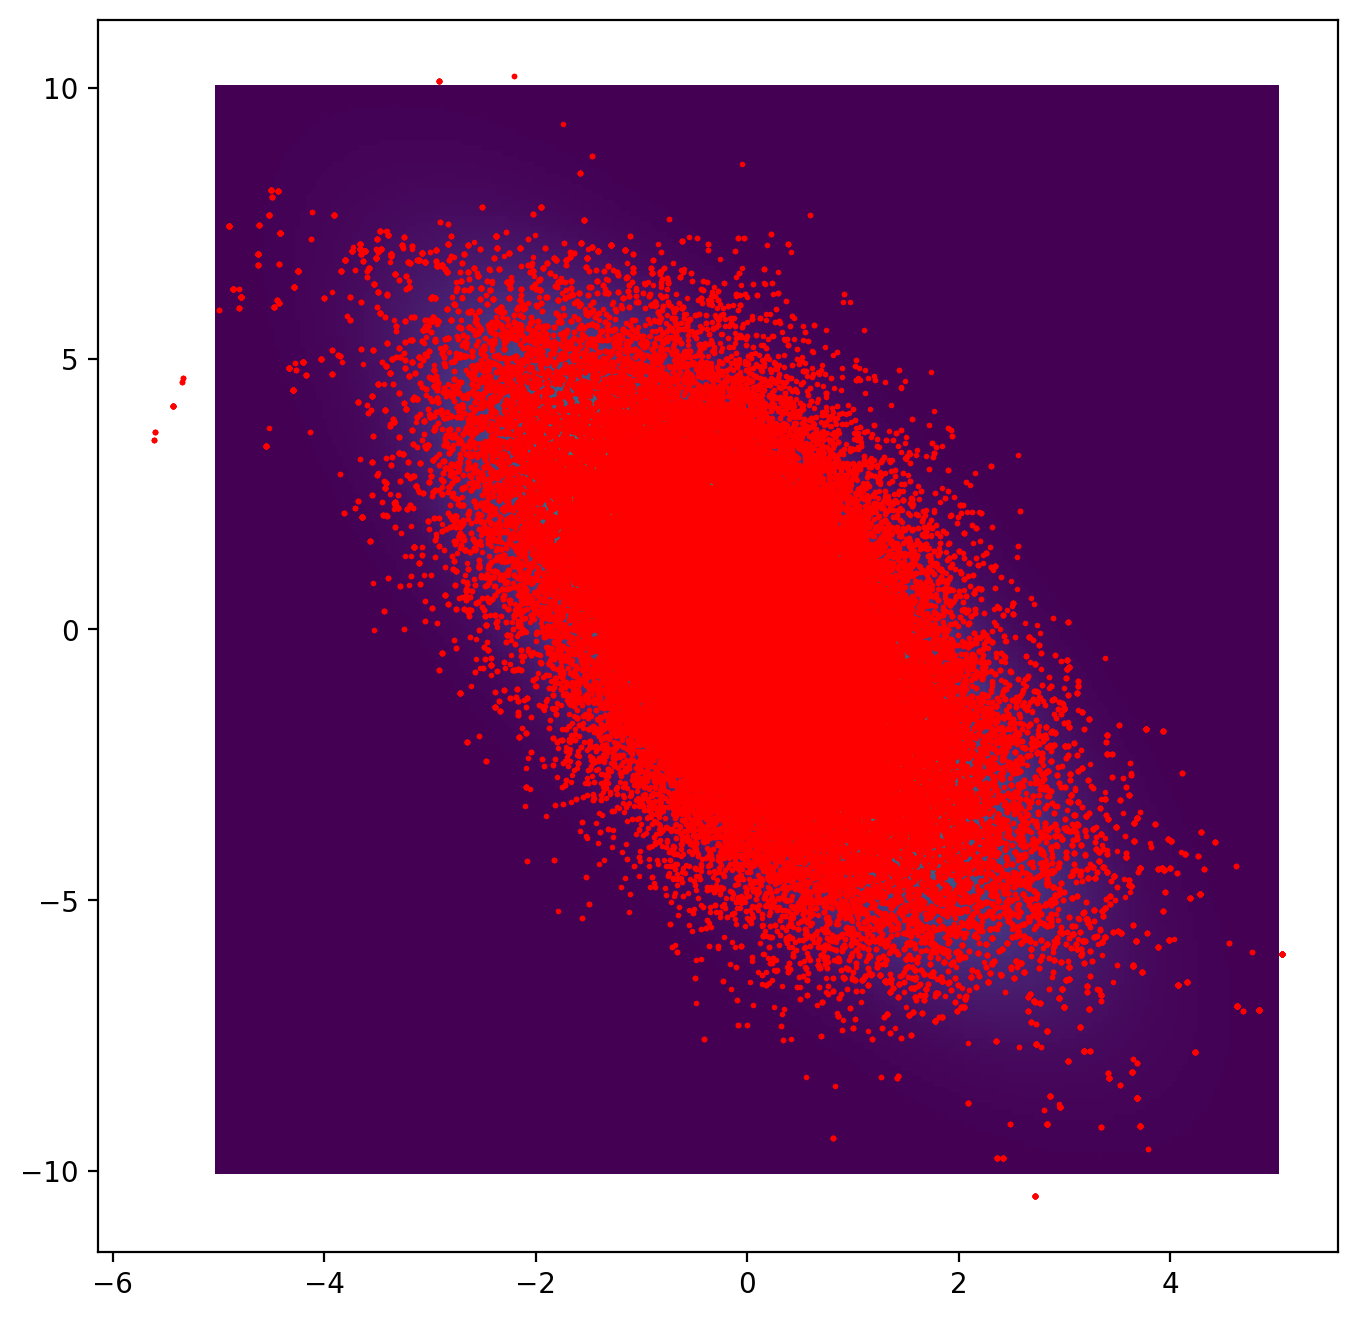

In [16]:
Xchain = array(Xchain)
x = linspace(-5, 5, 200)
y = linspace(-10, 10, 200)
X, Y = meshgrid(x, y)
Z = L(stack([X, Y], 2))
figure(1, [8, 8])
pcolor(X, Y, exp(Z))
plot(Xchain[..., 0].flatten(), Xchain[..., 1].flatten(), 'r.', ms=2)

In [17]:
tfp.mcmc.effective_sample_size(Xchain)

<tf.Tensor: shape=(16, 2), dtype=float64, numpy=
array([[352.62591158, 518.31894314],
       [ 65.24311462,  81.09280377],
       [ 59.29440288,  59.7460565 ],
       [361.16923177, 450.12306347],
       [343.3405601 , 486.71077646],
       [303.6362804 , 346.3888763 ],
       [121.09398927, 127.98604867],
       [193.68760634, 220.4354415 ],
       [280.16366183, 335.21769419],
       [400.24480132, 431.46515034],
       [354.41642891, 384.18802098],
       [163.78018214, 164.19902988],
       [210.68081872, 221.46373369],
       [184.91758988, 198.5429068 ],
       [483.85770854, 567.51052771],
       [321.8131865 , 345.21540757]])>

In [18]:
print('mean:', Xchain.mean(axis=(0, 1)))
print('estimated covariance:\n', cov(Xchain.reshape(-1, 2).T))
print('true covariance:\n', inv(M))

mean: [ 0.01340369 -0.04542837]
estimated covariance:
 [[ 1.94605252 -2.91963867]
 [-2.91963867  8.21424098]]
true covariance:
 [[ 1.89528992 -2.9273785 ]
 [-2.9273785   8.48189154]]


# Bijectors
Thursday